In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import os
import cv2
from perspective_transform import *
from lane_find import *
from color_filtering import *
from calib_camera import *
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

### Step by Step Detection of lane lines

#### 1. Camera Calibration

Calibrate the camera using the images in `camera_cal` directory

In [23]:
nx = 9
ny = 6
images = glob.glob("camera_cal/calibration*.jpg")
pickle_file = "camera_cal/dist_pickle.p"

In [24]:
# Find object and image points and use these to calibrate the camera
objpoints, imgpoints = find_obj_and_img_points(images, nx, ny)
mtx, dist = calibrate_camera(objpoints, imgpoints, (1280, 720))

# save required variables in a pickle file
dict_pickle = dict(objpoints=objpoints, imgpoints=imgpoints, mtx=mtx, dist=dist)
pickle.dump(dict_pickle, open(pickle_file, "wb"))

2019-09-29 12:33:24,931 - CalibCamera - INFO - Found corners on 17 images
2019-09-29 12:33:25,717 - CalibCamera - INFO - Returned mtx and dist from camera calibration


#### 2. Undistort and transform perspective

Let's use one image as an example and transform that into a bird-eye view after undistorting it

In [184]:
def plot_image(img, cv2_colormap=None, cmap=None, figsize=(24,9)):
    if cv2_colormap is not None:
        img = cv2.cvtColor(img, cv2_colormap)
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    
plot_color_image = partial(plot_image, cv2_colormap=cv2.COLOR_BGR2RGB)
plot_gray_image = partial(plot_image, cv2_colormap=cv2.COLOR_BGR2GRAY)
plot_bw_image = partial(plot_image, cmap="gray")

test2.jpg


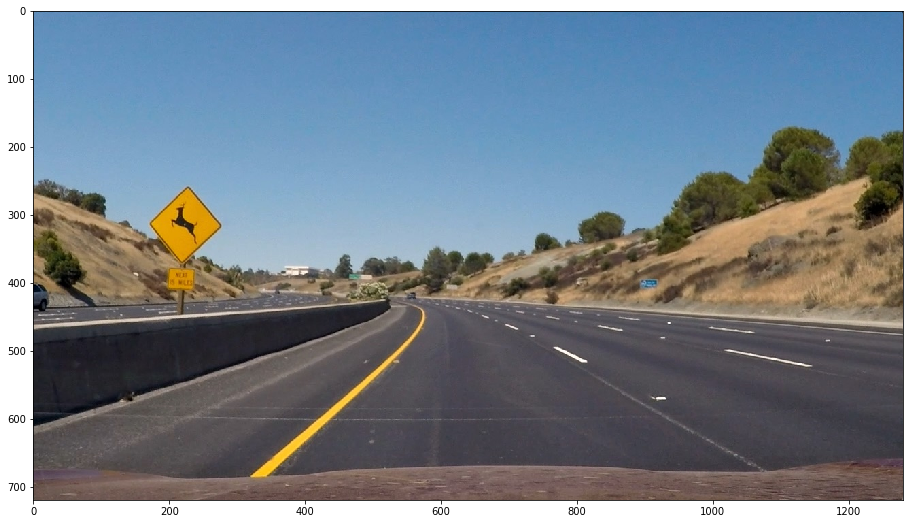

In [185]:
fnames = os.listdir("test_images")
idx = 5
fname = fnames[idx]
print(fname)
img = cv2.imread(os.path.join("test_images", fname))
plot_color_image(img)

In [37]:
# first load mtx and dist
pickle_file = "camera_cal/dist_pickle.p"
dict_pickle = pickle.load(open(pickle_file, "rb"))
mtx, dist = dict_pickle["mtx"], dict_pickle["dist"]

I experimented with various values for the source and destination polygons; 
after trying some values from the github repositories of former nanodegree students and have found these settings to be the best

In [71]:
src = np.float32(
      [[ 585,  460],
       [ 203,  720],
       [1126,  720],
       [ 695,  460]])

dst = np.float32(
      [[350,   0.],
       [350, 720.],
       [950, 720.],
       [950,   0.]])

In [230]:
warped_img, M = streetview2birdview(img, mtx, dist, src, dst, img_size=(img.shape[1], img.shape[0]))

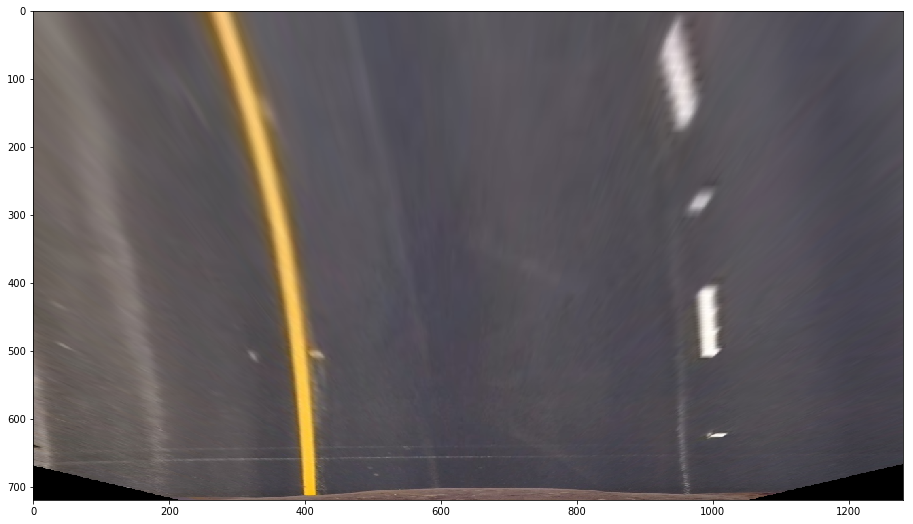

In [231]:
plot_color_image(warped_img) # seems plausible

#### Step 3: Color Thresholding

In [232]:
# Define various color thresholded binary images using different filters
grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
s_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
l_binary = hls_thresh(warped_img, hls_channel="L", thresh=(30, 100))
r_binary = rgb_thresh(warped_img, rgb_channel="R", thresh=(200, 255))
assert grad_binary.shape == mag_binary.shape == dir_binary.shape == s_binary.shape == warped_img.shape[:2] 

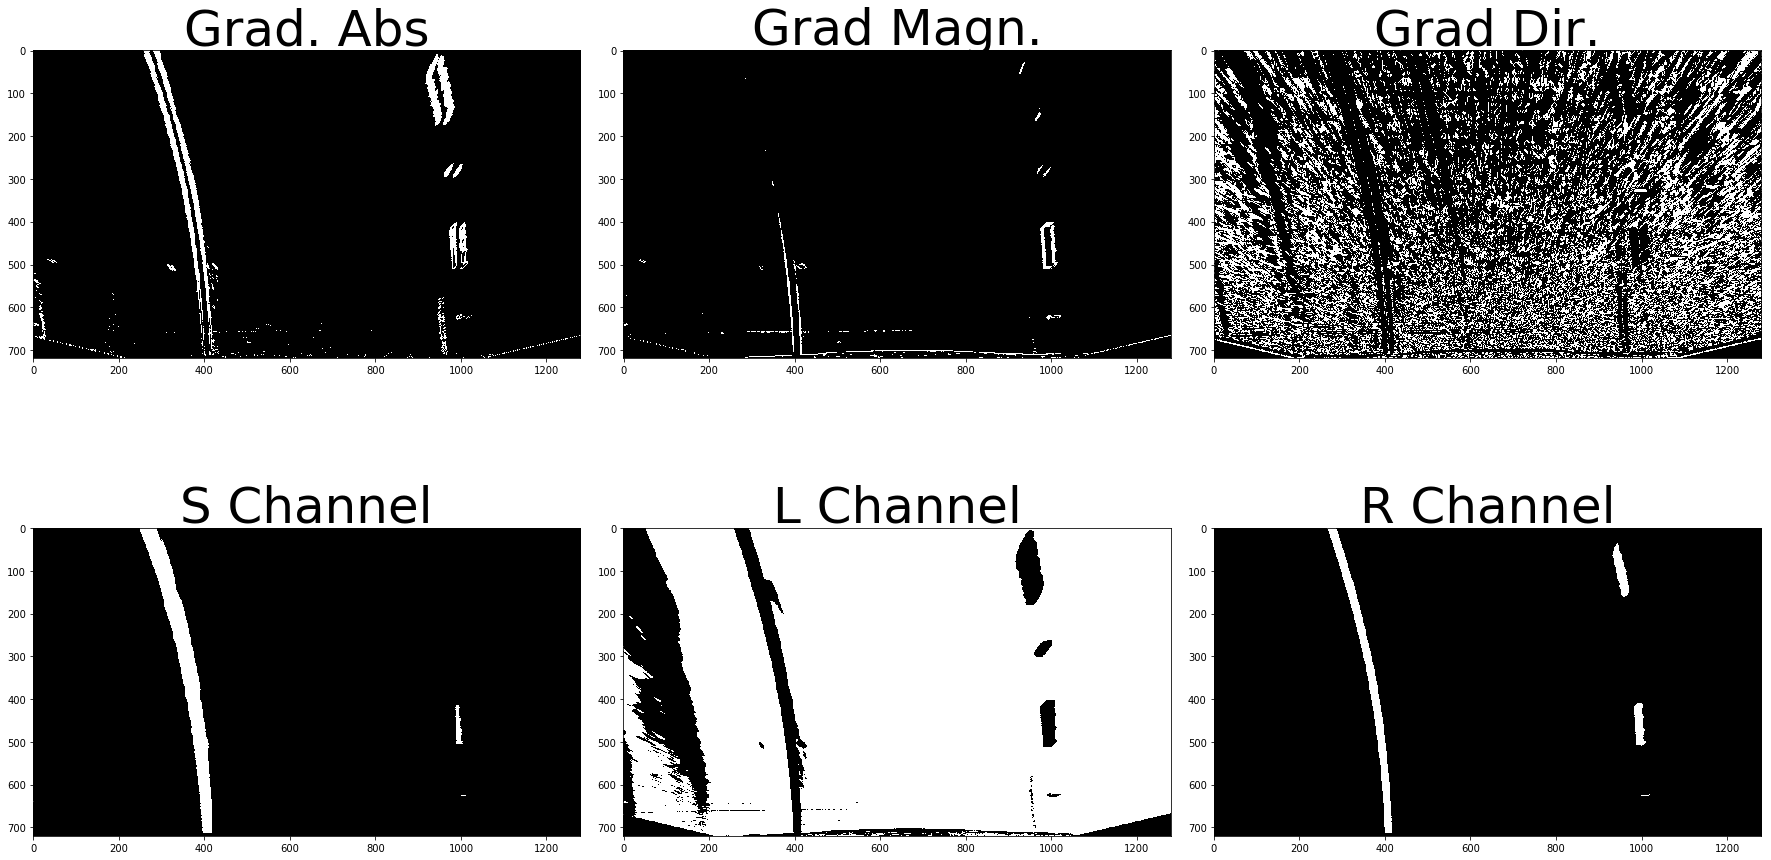

In [233]:
f, axes = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
axes[0][0].imshow(grad_binary, cmap="gray")
axes[0][0].set_title('Grad. Abs', fontsize=50)
axes[0][1].imshow(mag_binary, cmap='gray')
axes[0][1].set_title('Grad Magn.', fontsize=50)
axes[0][2].imshow(dir_binary, cmap='gray')
axes[0][2].set_title('Grad Dir.', fontsize=50)
axes[1][0].imshow(s_binary, cmap='gray')
axes[1][0].set_title('S Channel', fontsize=50)
axes[1][1].imshow(l_binary, cmap='gray')
axes[1][1].set_title('L Channel', fontsize=50)
axes[1][2].imshow(r_binary, cmap='gray')
axes[1][2].set_title('R Channel', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=1.4, bottom=0.)

In [234]:
# Combine thresholds, e.g. using the S and R channel
combined_binary = np.zeros_like(dir_binary)
# combined_binary[((hls_binary == 1) & (l_binary==0)) | (r_binary==1) | ((grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 0)))] = 1
combined_binary[((r_binary == 1) | (r_binary==1))] = 1

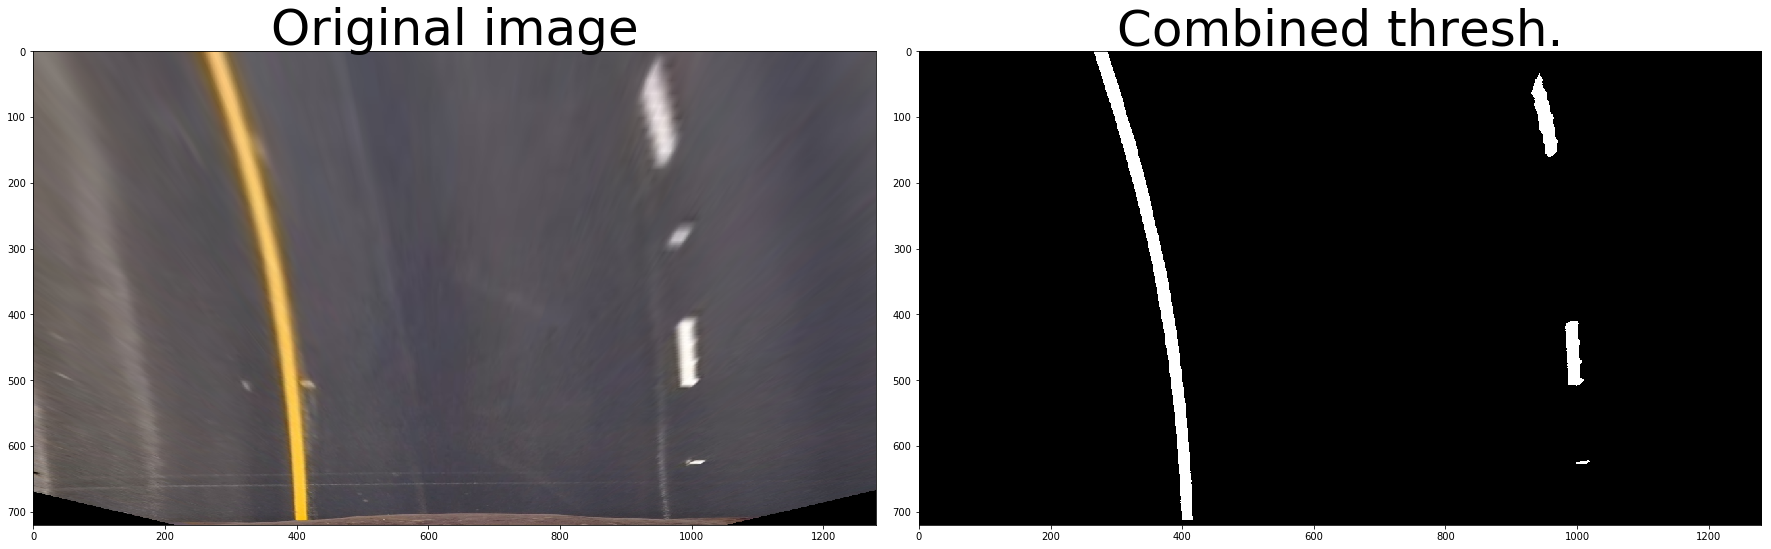

In [235]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined thresh.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Step 4: Find lane lines

From Scratch

In [236]:
left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary, draw_lanes=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


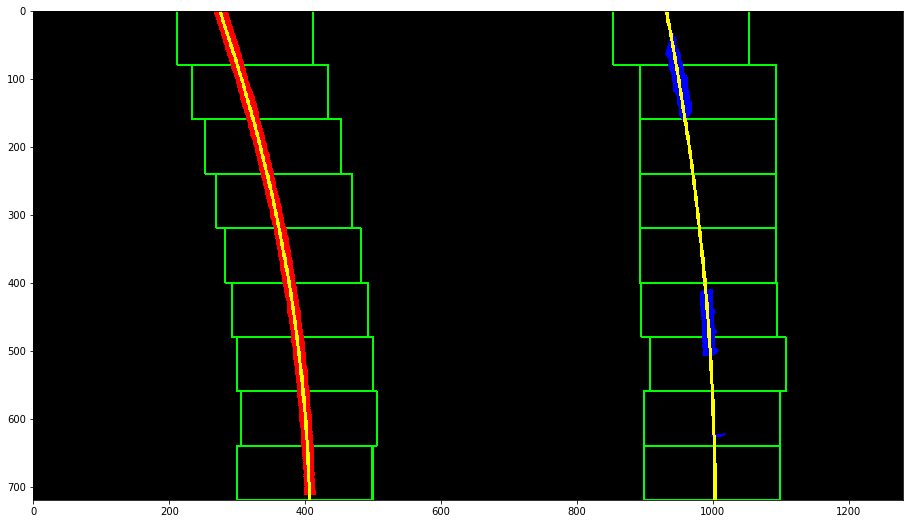

In [237]:
plot_image(out_img)


# red and blue are the detected pixels of left and right lane, respectively
# yellow is the fitted polynomial of second order to these pixels
# green denotes the sliding windows for finding the lane pixels

From Prior Search

In [94]:
# Note that when applied on videos, the previous image needs to be passed as input
left_fitx, right_fitx, _, _, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, left_fit, right_fit)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


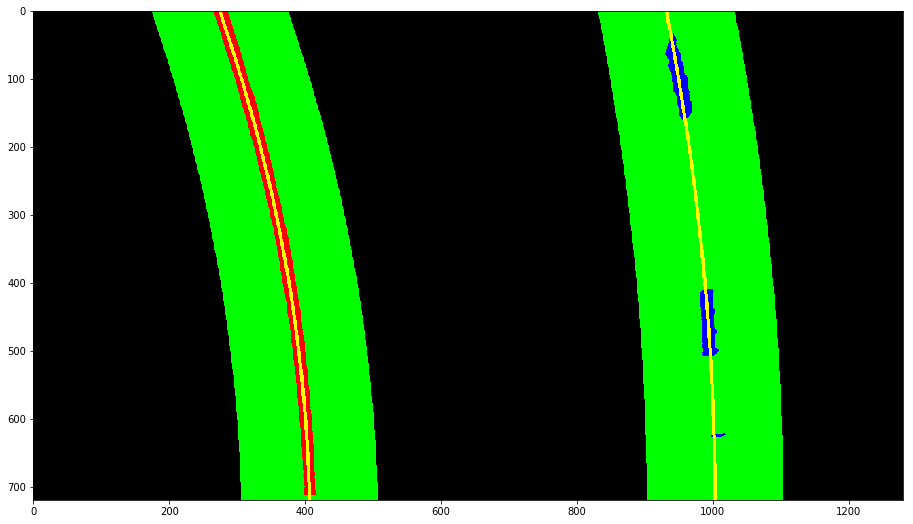

In [96]:
plot_image(out_img)  

# green denotes the margin around which the lanes are searched from the previously detected lane

#### 5. Calculate lane curvature and offset from road center


In [238]:
left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)

In [239]:
print(f"left curve radius: {left_curverad}m, right curve radius: {right_curverad}m")

left curve radius: 734.4011539746696m, right curve radius: 1238.6782621213688m


In [240]:
offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)

In [241]:
print(f"Offset is {offset}m")

Offset is -0.34449486646887134m


#### 6. Warp back detected lanes to original image

In [242]:
img_with_lane = birdview2streetview(out_img, img, combined_binary, dst, src, left_fitx, right_fitx, ploty)

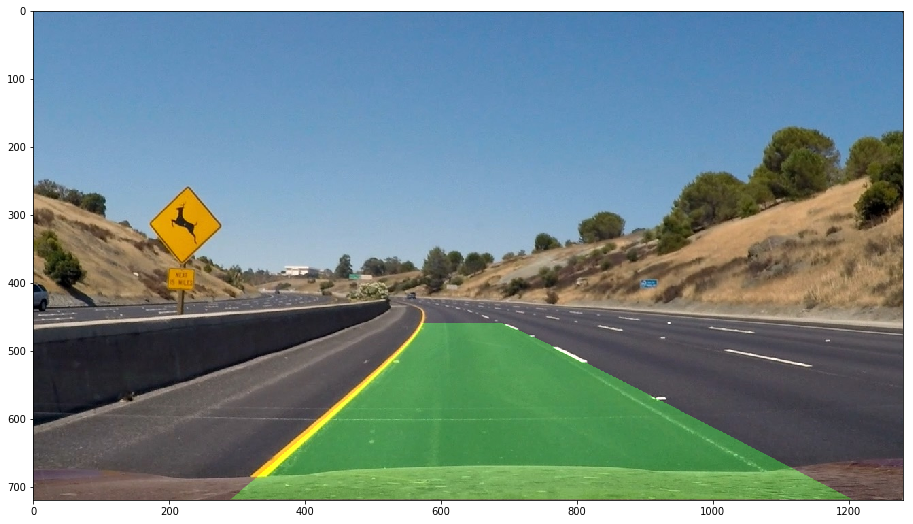

In [243]:
plot_image(img_with_lane)

#### 7. Project curvatures and offset values onto image

In [118]:
img_with_lane = show_crv_and_offset(img_with_lane, left_curverad, right_curverad, offset)

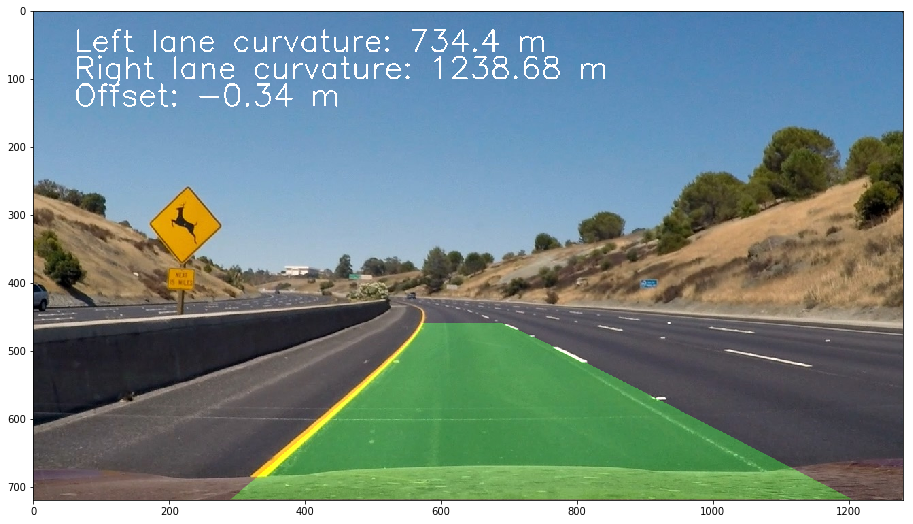

In [119]:
plot_image(img_with_lane)

### Pipeline

Let's go through the entire lane detection pipeline on all the images in `test_images` folder and save the result to `output_images`

In [160]:
# Run the previous cells from above to obtain mtx, dist, src and dst

In [257]:
# Let's define some helper functions/wrappers
def warp_to_orig(out_img, orig_img, combined_binary, dst, src, left_fitx, right_fitx, ploty, left_crv, right_crv, offset):
    img_with_lane = birdview2streetview(out_img, orig_img, combined_binary, dst, src, left_fitx, right_fitx, ploty)
    img_with_lane = show_crv_and_offset(img_with_lane, left_crv, right_crv, offset)
    return img_with_lane

def hls_rgb_thresh(img, hls_channel, rgb_channel, hls_threshold, rgb_threshold):
    # For the sake of demonstration, let's only use the thresholding from HLS and RGB space
    s_binary = hls_thresh(img, hls_channel=hls_channel, thresh=hls_threshold)
    r_binary = rgb_thresh(img, rgb_channel=rgb_channel, thresh=rgb_threshold)
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((s_binary == 1) | (r_binary==1))] = 1
    return combined_binary

def calc_lane_crv_and_offset(left_fitx, right_fitx, ploty, midpoint):
    left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
    offset = measure_offset(left_fitx, right_fitx, midpoint)
    return left_curverad, right_curverad, offset

In [258]:
# First we define a wrapper function for the entire pipeline
# Note that the camera does not need to be calibrated again

def lane_detection_pipeline(img, warp_func, color_thresh_func, find_lanes_func, calc_lane_params_func, warp_back_func):
    # Transform to bird-eye perspective
    warped_img, M = warp_func(img)
    # Color Threshold
    combined_binary = color_thresh_func(warped_img)
    # Detect lane lines (for the sake of this exercise, let's do it from scratch)
    left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_func(combined_binary)
    # Calculate curvature and offset
    left_curverad, right_curverad, offset = calc_lane_params_func(left_fitx, right_fitx, ploty)
    # Warp back to original image and project onto original image
    img_with_lane = warp_back(out_img=out_img, orig_img=img, combined_binary=combined_binary, left_fitx=left_fitx, 
                          right_fitx=right_fitx, ploty=ploty, left_crv=left_crv, right_crv=right_crv, offset=offset)
    # Return all intermediate steps for visualization
    return warped_img, combined_binary, out_img, img_with_lane

In [259]:
warp = partial(streetview2birdview, mtx=mtx, dist=dist, src=src, dst=dst, img_size=(1280, 720))
color_thresh = partial(hls_rgb_thresh, hls_channel="S", rgb_channel="R", hls_threshold=(90, 255), rgb_threshold=(200, 255))
calc_lane_params = partial(calc_lane_crv_and_offset, midpoint=640)
warp_back = partial(warp_to_orig, dst=dst, src=src)

In [292]:
def plot_pipeline(fname, warped_img, combined_binary, out_img, img_with_lane, savefig=True):
    
    img = cv2.imread(os.path.join("test_images", fname))
    
    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(24, 9))
    f.tight_layout()
    ax0.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax0.set_title(f'{fname}', fontsize=20)
    ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Warped', fontsize=20)
    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('Combined thresh.', fontsize=20)
    ax3.imshow(out_img, cmap='gray')
    ax3.set_title('Lane pixels', fontsize=20)
    ax4.imshow(img_with_lane)
    ax4.set_title('Detected lanes', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    if savefig:
        out_file = os.path.join("output_images", f"{fname}_warped.jpg")
        cv2.imwrite(out_file, cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
        
        out_file = os.path.join("output_images", f"{fname}_colorthresh.jpg")
        cv2.imwrite(out_file, combined_binary*255)
        
        out_file = os.path.join("output_images", f"{fname}_lanesearch.jpg")
        cv2.imwrite(out_file, cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        
        out_file = os.path.join("output_images", f"{fname}_withlanes.jpg")
        cv2.imwrite(out_file, cv2.cvtColor(img_with_lane, cv2.COLOR_RGB2BGR))

In [293]:
warped_img, combined_binary, out_img, img_with_lane = lane_detection_pipeline(img, warp_func=warp, 
                                                                              color_thresh_func=color_thresh,
                                                                              find_lanes_func=find_lanes_from_scratch,
                                                                              calc_lane_params_func=calc_lane_params,
                                                                              warp_back_func=warp_back)

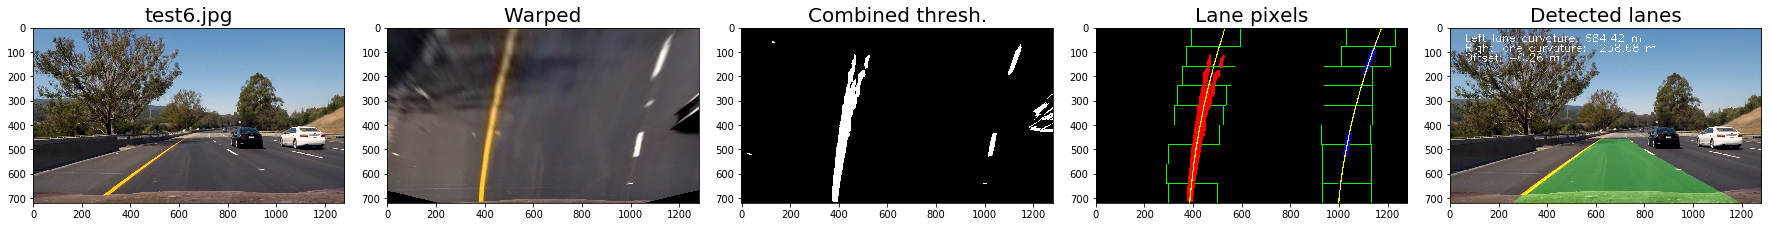

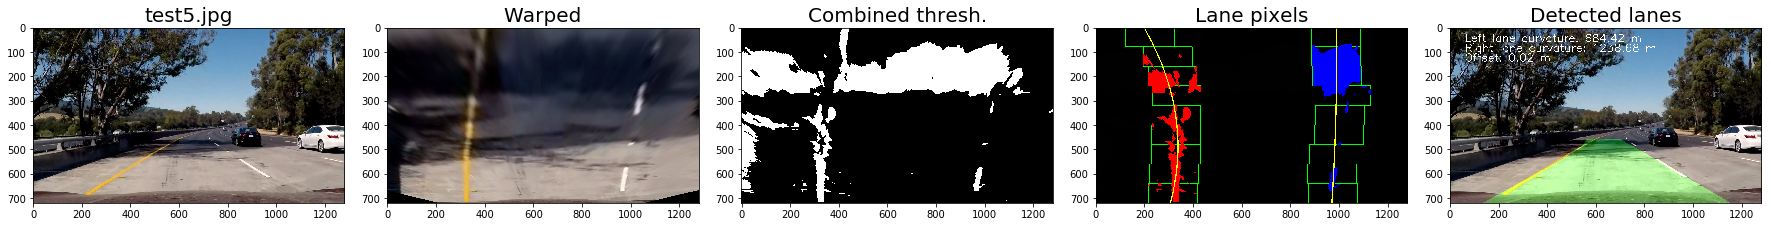

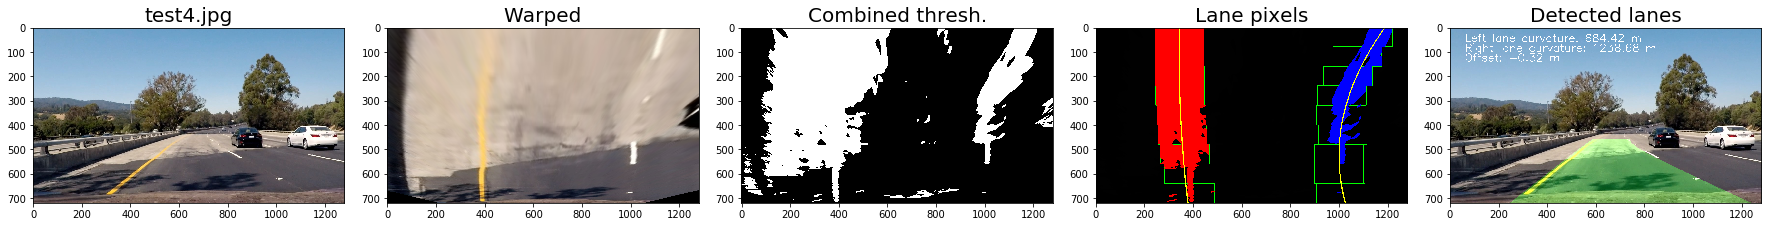

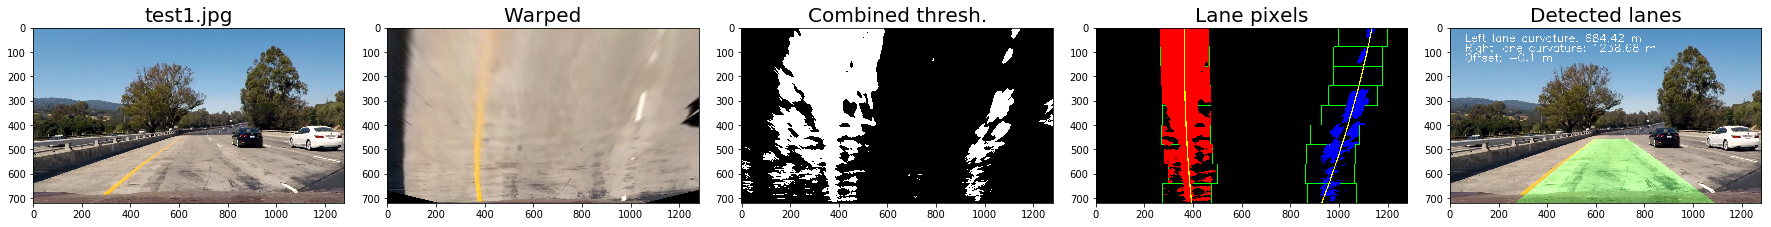

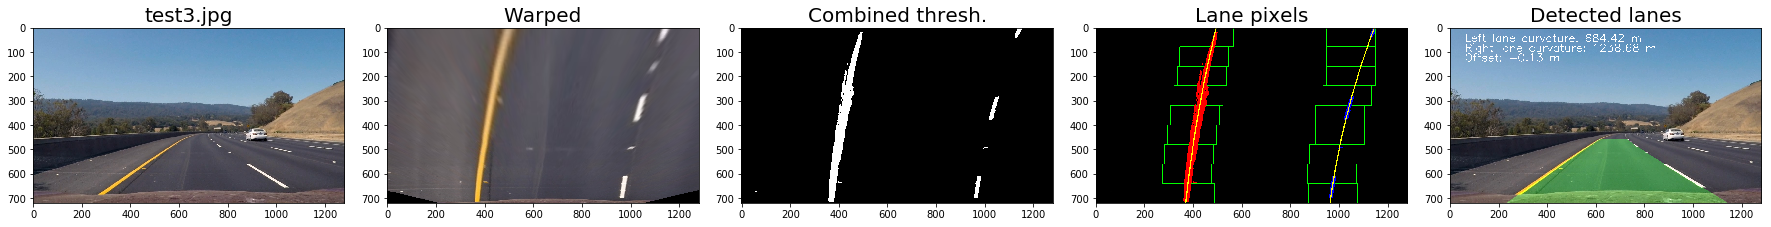

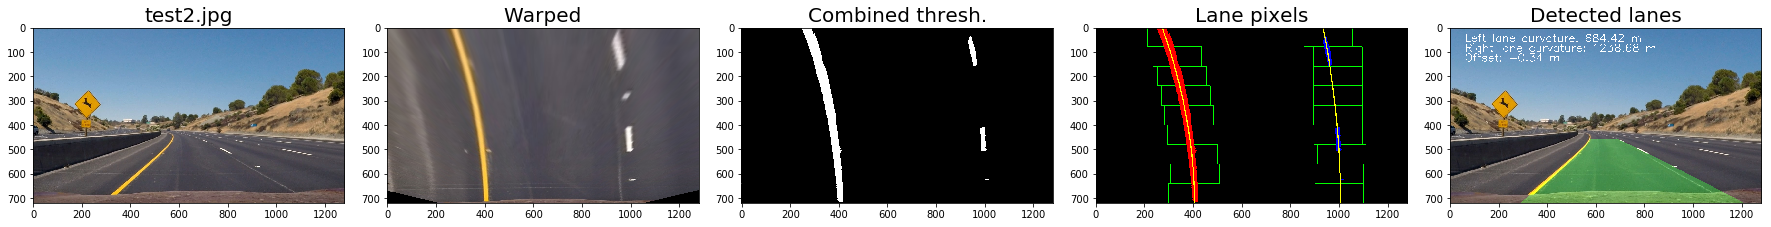

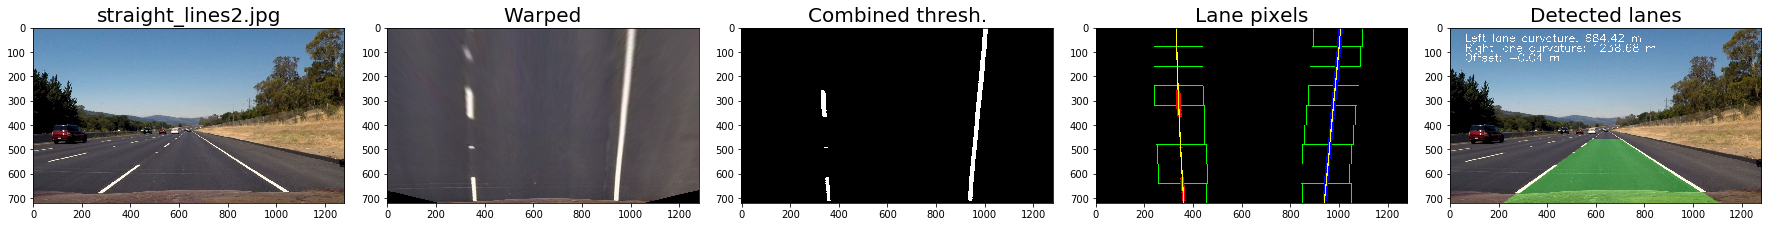

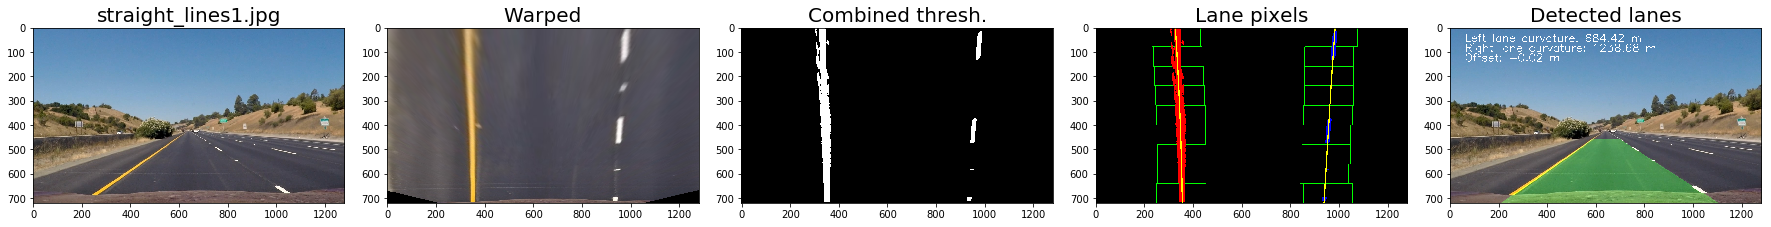

In [294]:
for fname in fnames:
    img = cv2.imread(os.path.join("test_images", fname))
    warped_img, combined_binary, out_img, img_with_lane = lane_detection_pipeline(img, warp_func=warp, 
                                                                              color_thresh_func=color_thresh,
                                                                              find_lanes_func=find_lanes_from_scratch,
                                                                              calc_lane_params_func=calc_lane_params,
                                                                              warp_back_func=warp_back)
    plot_pipeline(fname, warped_img, combined_binary, out_img, img_with_lane)

We can see that the R channel in RGB space produces very clear filtered images of both lines when the image is clear. 
However it does not seem to be robust to changing environments, such as different lighting or shadows.

### Test on video

Define class which stores attributes across frames

In [28]:
import imageio
imageio.plugins.ffmpeg.download()

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [138]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        # self.current_fit = [np.array([False])]  
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.not_found_counter = 0
        self.initial_scratch_search = True
        self.continuous_frames_with_no_lanes = 5
        self.frame_counter = 0
        self.frame_buffer = 12
        self.lane_margin = None  # ToDo: set this
        # ToDo: some attributes should be properties
        # ToDo: set the other attributes as well
        # ToDo: add frame_counter to count all frames (to know how many frames per second)  # 24 frames per second

In [106]:
# search from scratch always has to find something
# search from prior does not necessarily have to find something

# search from scratch: first frame of video or when nothing has been found from priors

# could be that leftx, lefty ... have to be passed out of the function as well!

In [107]:
def append_or_replace(l_list, index, item, list_len=5):
    if len(l_list)<list_len:
        l_list.append(item)
    else:
        l_list[index] = item
    assert len(l_list)<=list_len

In [161]:
def process_image(image):
    warped_img, M = perspective_transform(image, mtx, dist, src, dst, img_size=(image.shape[1], image.shape[0]))
    
    grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
    mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
    dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
    s_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 0)))] = 1
    # combined_binary[(s_binary == 1) | (r_binary == 1) | ((mag_binary == 1) & (dir_binary == 0))] = 1  # the r and luv_l channel are not robust to changing conditions!
    
    
    # Enforce search from scratch on frame 0
    if leftlane.initial_scratch_search or rightlane.initial_scratch_search:
        left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
        leftlane.detected, rightlane.detected = True, True
        leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
        leftlane.initial_scratch_search, rightlane.initial_scratch_search = False, False
        # leftlane.recent_xfitted.append(left_fitx), rightlane.recent_xfitted.append(right_fitx)
        
    if not leftlane.detected or not rightlane.detected:  # if no lane detected for 30 frames, search from scratch (technically better to separate left and right lanes)
        leftlane.not_found_counter += 1
        rightlane.not_found_counter += 1
        if leftlane.not_found_counter < leftlane.continuous_frames_with_no_lanes:
            result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
            return result
        else:
            print(f"nothing lanes for {leftlane.continuous_frames_with_no_lanes} frames... search from scratch")
            left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
            leftlane.detected, rightlane.detected = True, True
            leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
            leftlane.not_found_counter, rightlane.not_found_counter = 0, 0  # reset counter
    else:  # if lanes detected previously, search from prior
        left_fitx, right_fitx, leftlane.current_fit, rightlane.current_fit, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, leftlane.current_fit, rightlane.current_fit, margin=100)
        leftlane.detected = detected_flag  
        rightlane.detected = detected_flag
        leftlane.not_found_counter, rightlane.not_found_counter = 0, 0  # reset counter
        # leftlane.recent_xfitted.append(left_fitx), rightlane.recent_xfitted.append(right_fitx)
        
    append_or_replace(leftlane.recent_xfitted, leftlane.frame_counter%leftlane.frame_buffer, left_fitx, list_len=leftlane.frame_buffer)
    append_or_replace(rightlane.recent_xfitted, rightlane.frame_counter%rightlane.frame_buffer, right_fitx, list_len=rightlane.frame_buffer)
    try:  # to avoid a bad start (might happen when margin is set too small)
        left_fitx = np.median(np.array([x for x in leftlane.recent_xfitted if x is not None]), axis=0)  # using median because more robust against outliers
        right_fitx = np.median(np.array([x for x in rightlane.recent_xfitted if x is not None]), axis=0)
    except:
        print("cannot take the median")
        pass
    #left_fitx = np.median(np.array([x for x in leftlane.recent_xfitted if x is not None]), axis=0)
    #right_fitx = np.median(np.array([x for x in rightlane.recent_xfitted if x is not None]), axis=0)
    
    try:
        left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
        offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)
        leftlane.radius_of_curvature, rightlane.radius_of_curvature = left_curverad, right_curverad
        leftlane.line_base_pos, rightlane.line_base_pos = offset, offset
        img_with_lane = warp_back(out_img, image, combined_binary, dst, src, left_fitx, right_fitx, ploty)
        result = show_crv_and_offset(img_with_lane, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    except:
        result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    
    leftlane.frame_counter+=1
    rightlane.frame_counter+=1
    
    if leftlane.frame_counter == leftlane.frame_buffer or rightlane.frame_counter == rightlane.frame_buffer:
        leftlane.frame_counter, rightlane.frame_counter = 0, 0
    
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [162]:
leftlane = Line()
rightlane = Line()
input_video = './harder_challenge_video.mp4'
output_video = './harder_challenge_video_result.mp4'
#output_video = './harder_challenge_video_solution.mp4'
## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False, progress_bar=False)

[MoviePy] >>>> Building video ./harder_challenge_video_result.mp4
[MoviePy] Writing video ./harder_challenge_video_result.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_result.mp4 

CPU times: user 3min 28s, sys: 55.3 s, total: 4min 23s
Wall time: 3min 32s


In [163]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

- can enforce searching from scratch by setting a very small margin
- separate left and right searching (don't need to search frmo scratch for both)
- add sanity check if min of right_lane  is smaller than max of left line (meaning both intersect) -> or use smaller src, dst windows
- calculate lane width, if too large or negative: search from scratch
- return leftx, lefty etc. to fit poly on average of those
- if curvatures diverge too much (by factor of 10), mirror more plausible curvature on left/right lane; start point is on bottom of image (since those 
are detected most reliably)
- fit more complex polynomial (order=3 or more)
- making the road "skinnier" kind of works better

Unused Code

In [414]:
# lets do it step by step
binary_warped = combined_binary
histogram = hist(binary_warped) # sum over pixel values of bottom half image -> peaks indicate lines
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) # create output image to draw on (not necessary)
midpoint = np.int(histogram.shape[0]//2)  # 640
leftx_base = np.argmax(histogram[:midpoint])  # find index of left peak (indicates ll)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint # find index of right peak (indicates rl)
nwindows = 9
margin = 100
minpix = 50
window_height = np.int(binary_warped.shape[0]//nwindows)  # 80
nonzero = binary_warped.nonzero()  # a tuple for x and y
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx_current = leftx_base
rightx_current = rightx_base
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):  # index 0 to 8
    win_y_low = binary_warped.shape[0] - (window+1)*window_height  
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) # bottom left to top right, in green, with thickness 2
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
            (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
        (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)  # indices
    right_lane_inds.append(good_right_inds)
    if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
        # print(leftx_current)
    if len(good_right_inds) > minpix:
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, deg=2)
right_fit = np.polyfit(righty, rightx, deg=2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
for index in range(binary_warped.shape[0]):
    cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
    cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))

In [ ]:
def process_image(image):
    warped_img, M = perspective_transform(image, mtx, dist, src, dst, img_size=(image.shape[1], image.shape[0]))
    
    mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
    dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
    hls_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(hls_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 0)))] = 1
    
    if not leftlane.detected or not rightlane.detected:  # if no lane detected, search from scratch (technically better to separate left and right lanes)
        print("have to search from scratch")
        left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
        leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
        leftlane.detected, rightlane.detected = True, True
        leftlane.search_from_scratch_counter += 1
        rightlane.search_from_scratch_counter += 1
    else:  # if lanes detected previously, search from prior
        left_fitx, right_fitx, leftlane.current_fit, rightlane.current_fit, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, leftlane.current_fit, rightlane.current_fit, margin=10)
        leftlane.detected = detected_flag  
        rightlane.detected = detected_flag
    
    try:
        left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
        offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)
        leftlane.radius_of_curvature, rightlane.radius_of_curvature = left_curverad, right_curverad
        leftlane.line_base_pos, rightlane.line_base_pos = offset, offset
        img_with_lane = warp_back(out_img, image, combined_binary, dst, src, left_fitx, right_fitx, ploty)
        result = show_crv_and_offset(img_with_lane, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    except:
        result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [140]:
# warp to birds eye-view
src = np.float32([[490, 482],
                  [810, 482],  # 482
                  [1250, 720],
                  [40, 720]])
dst = np.float32([[0, 0], 
                  [1280, 0], 
                  [1250, 720],
                  [40, 720]])

In [107]:
src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

In [6]:
# counter clockwise: top left, bottom left, bottom right, top right
src = np.float32(
      [[ 585,  460],
       [ 203,  720],
       [1126,  720],
       [ 695,  460]])

dst = np.float32(
      [[320,   0.],
       [320, 720.],
       [960, 720.],
       [960,   0.]])